In [65]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter, FuncFormatter

sns.set(style="white")

/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv


<img src="https://seismic.com/wp-content/uploads/2014/09/3-Ways-to-Improve-Sales-Synergy.png" alt="Sales Image" width="800"/>

# 💹 Sales 🤖 EDA, 4AB Testing & Predictive Modeling

> In this notebook we are going to work with [Kaggles Clicks Conversion Tracking dataset](https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking/data) which contains data from an anonymous organisation’s social media ad campaign. The objective of this notebook is to perform
>
> - 📊✨ informative and nicely-looking descriptive analysis and EDA
> 
> - 💹🔍 conversion rate, segment, cost efficiency and campaign performance analysis 
> 
> - 🔄🧪 A/B testing 
> 
> - 🤖📈 predictive modeling

In [2]:
sales = pd.read_csv('/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv')
print(f"Rows: {sales.shape[0]:,}")
print(f"Cols: {sales.shape[1]:,}")
print(sales.dtypes)
sales.head(3)

Rows: 1,143
Cols: 11
ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0


# Descriptive Analysis

In this section we are going to take a look at some summary statistics for the numerical variables. Additionally we are going to investigate the cardinalities of the categorical columnns.

In [3]:
# --- Basic statistics ---
pd.DataFrame(
    {
        'Data Type': sales.dtypes,
        'Missing Count (#)': sales.isnull().sum(),
        'Missing Rate (%)': 100 * sales.isnull().mean(),
        'Unique Count (#)': sales.nunique(),
        'Unique Rate (%)': round(100 * sales.nunique() / sales.shape[0], 2),
        'Duplicates Count (#)': [sales[c].duplicated().sum() for c in sales.columns],
        'Duplicates Rate (%)': [round(100 * sales[c].duplicated().sum() / sales.shape[0], 2) for c in sales.columns],
    }
)

,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
ad_id,int64,0,0.0,1143,100.00,0,0.00
xyz_campaign_id,int64,0,0.0,3,0.26,1140,99.74
fb_campaign_id,int64,0,0.0,691,60.45,452,39.55
age,object,0,0.0,4,0.35,1139,99.65
gender,object,0,0.0,2,0.17,1141,99.83
interest,int64,0,0.0,40,3.50,1103,96.50
Impressions,int64,0,0.0,1130,98.86,13,1.14
Clicks,int64,0,0.0,183,16.01,960,83.99
Spent,float64,0,0.0,869,76.03,274,23.97
Total_Conversion,int64,0,0.0,32,2.80,1111,97.20


- There are no missing values in the dataset 😊. 
- The dataset contains data of __1143 adds__.
- There are only __3 xyz campaigns__ in the dataset.
- There are __691 Facebook campaigns__ in the dataset.
- The customers are segmented into 4 age buckets.

## Numerical Variables

In [7]:
sales_numericals = sales.select_dtypes(include=['int64', 'float64'])

sales_numericals.describe().apply(lambda s: s.apply(lambda x: f"{x:,.2f}"))

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,"1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00"
mean,"987,261.13","1,067.38","133,783.99",32.77,"186,732.13",33.39,51.36,2.86,0.94
std,"193,992.81",121.63,"20,500.31",26.95,"312,762.18",56.89,86.91,4.48,1.74
min,"708,746.00",916.00,"103,916.00",2.00,87.00,0.00,0.00,0.00,0.00
25%,"777,632.50",936.00,"115,716.00",16.00,"6,503.50",1.00,1.48,1.00,0.00
50%,"1,121,185.00","1,178.00","144,549.00",25.00,"51,509.00",8.00,12.37,1.00,1.00
75%,"1,121,804.50","1,178.00","144,657.50",31.00,"221,769.00",37.50,60.02,3.00,1.00
max,"1,314,415.00","1,178.00","179,982.00",114.00,"3,052,003.00",421.00,639.95,60.00,21.00


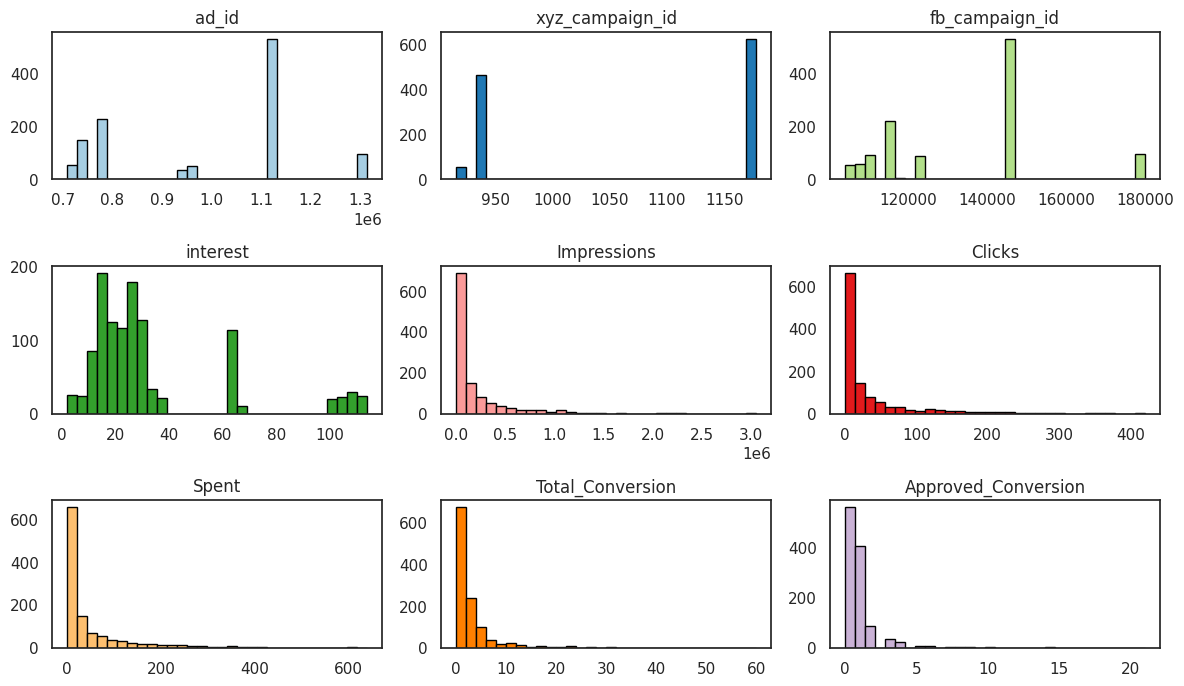

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7))
axes = axes.flatten()

colors = sns.color_palette("Paired", 9)

for i, col in enumerate(sales_numericals):
    ax = axes[i]
    ax.hist(sales[col].dropna(), bins=30, color=colors[i % len(colors)], edgecolor='black')
    ax.set_title(col)
    
    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')    

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

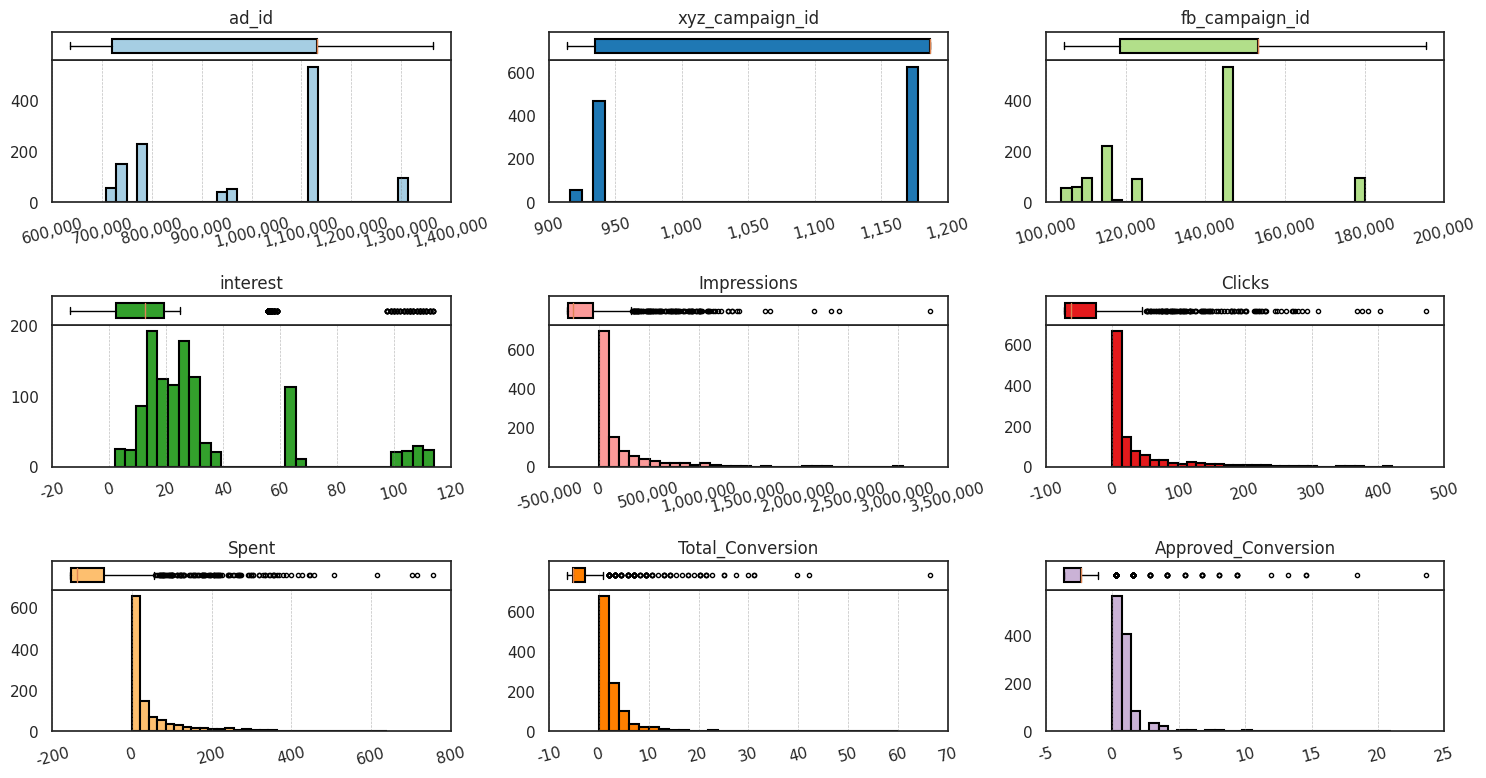

In [76]:
fig, axes = plt.subplots(3, 3, figsize=(15, 8))
axes = axes.flatten()

def comma_formatter(x, pos):
    return f'{x:,.0f}'

for i, col in enumerate(sales_numericals):
    ax_hist = axes[i]
    
    # --- Boxplot ---
    ax_box = ax_hist.inset_axes([0, 1, 1, 0.2])
    ax_box.boxplot(
        sales[col].dropna(), 
        vert=False, 
        patch_artist=True, 
        widths=0.5,
        boxprops=dict(facecolor=colors[i], linewidth=1.5), 
        flierprops=dict(marker='o', markersize=3, linestyle='none')
    )
    ax_box.set_yticks([])
    ax_box.set_xticks([])

    # --- Histogram ---
    ax_hist.hist(sales[col].dropna(), bins=30, color=colors[i], linewidth=1.5, edgecolor='black')
    ax_hist.set_title(col)
    ax_hist.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax_hist.ticklabel_format(style='plain', axis='y')  
    
    # Disable scientific notation on both x and y-axis.
    ax_hist.ticklabel_format(style='plain', axis='x')
    ax_hist.ticklabel_format(style='plain', axis='y')
    
    # Ensure that no offset is used.
    ax_hist.xaxis.get_major_formatter().set_useOffset(False)
    ax_hist.yaxis.get_major_formatter().set_useOffset(False)  
    ax_hist.xaxis.set_major_formatter(FuncFormatter(comma_formatter))
    
    # Set the x-ticks explicitly and add vertical lines at each x-tick.
    xticks = ax_hist.get_xticks()
    ax_hist.set_xticks(xticks)
    ax_hist.set_xticklabels([f'{int(x):,}' for x in xticks])
    plt.setp(ax_hist.get_xticklabels(), rotation=15, ha='center')
    
    for tick in xticks:
        ax_hist.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)
        
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

- We see that one `ad_id` and one `fb_campaign_id` are in the large majority of the dataset.

## Categorical Variables

In [79]:
sales_categoricals = sales.select_dtypes(exclude=['int64', 'float64'])

sales_categoricals.value_counts()

age    gender
30-34  M         229
       F         197
35-39  M         139
45-49  F         138
       M         121
35-39  F         109
40-44  F         107
       M         103
Name: count, dtype: int64

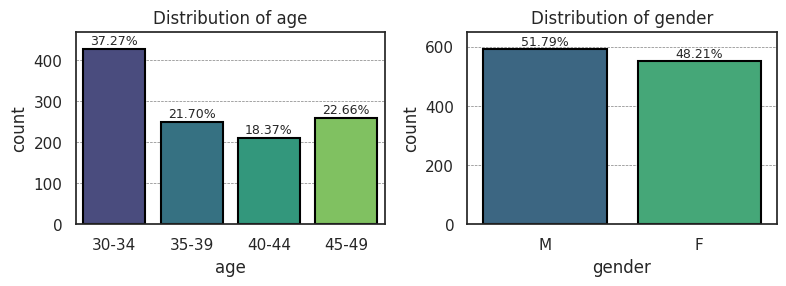

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

for i, col in enumerate(sales_categoricals):
    ax = axes[i]
    
    plot = sns.countplot(data=sales, x=col, 
                         palette='viridis', edgecolor='black', linewidth=1.5, 
                         ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)    
    
    # Add percentage at the top of each bar.
    total = len(sales[col])
    max_height = 0
    for p in plot.patches:
        height = p.get_height()
        max_height = max(max_height, height)
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2., height + 12, 
                f'{percentage:.2f}%', ha='center', fontsize=9)

    ax.set_ylim(0, max_height * 1.10)
    

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

# Exploratory Data Analysis (EDA)

# Conversion Rate Analysis

# Segment Analysis

# Cost Efficiency Analysis

# Campaign Performance Analysis

# A/B Testing Analysis

# Predictive Modeling

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏